# US Census Segmentation using PCA and K-means clustering

Typically for machine learning problems, clear use cases are derived from labelled data. For example, based on the attributes of a device, such as its age or model number, we can predict its likelihood of failure. We call this supervised learning because there is supervision or guidance towards predicting specific outcomes.
However, in the real world, there are often large data sets where there is no particular outcome to predict, where clean labels are hard to define. It can be difficult to pinpoint exactly what the right outcome is to predict. This type of use case is often exploratory. It seeks to understand the makeup of a dataset and what natural patterns exist. This type of use case is known as unsupervised learning. One example of this is trying to group similar individuals together based on a set of attributes.
The use case this blog post explores is population segmentation. We have taken publicly available, anonymized data from the US census on demographics by different US counties: https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml. (Note that this product uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.) The outcome of this analysis are natural groupings of similar counties in a transformed feature space.

This technique can be applied by businesses in customer or user segmentation to create targeted marketing campaigns. So this notebook demonstrates how we can access the underlying models that are built within Amazon SageMaker to extract useful model attributes.

In [1]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import time
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import boto3
import botocore
from botocore.exceptions import ClientError

import csv
import io
import re
import s3fs
import mxnet as mx
import seaborn as sns
import pickle
import gzip
import urllib
import csv


import sagemaker                                 
from sagemaker.predictor import csv_serializer 
from sagemaker.predictor import json_deserializer
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role

### 1. Preparation (Specifying Sagemaker roles)

In [2]:
sess   = sagemaker.Session()
bucket = sess.default_bucket()                     
prefix = 'PCA-K-means'
region = boto3.Session().region_name
role = 'arn:aws:iam::570447867175:role/SageMakerNotebookRole' # pass your IAM role name

s3_client = boto3.client('s3')
data_bucket_name='census-segmentation'

print('Sagemaker session :', sess)
print('S3 bucket :', bucket)
print('Prefix :', prefix)
print('Region selected :', region)
print('IAM role :', role)

Sagemaker session : <sagemaker.session.Session object at 0x000001EA2E789408>
S3 bucket : sagemaker-us-west-2-570447867175
Prefix : PCA-K-means
Region selected : us-west-2
IAM role : arn:aws:iam::570447867175:role/SageMakerNotebookRole


### 2. Load Data

Dataset can be directly donwloaded from Kaggle DataSet for US Census [Link](https://www.kaggle.com/muonneutrino/us-census-demographic-data?select=acs2015_county_data.csv) 

In [3]:
path = 'C:\\Users\\bokhy\\Desktop\\Python\\github\\amazon-sagemaker\\data'  # Set path
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)   

In [4]:
counties = pd.read_csv(os.path.join(path, 'datasets_7001_312628_acs2015_county_data.csv'), header=0, delimiter=",", low_memory=False)
counties.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,51281.0,2391.0,24974,1080,12.9,18.6,33.2,17.0,24.2,8.6,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,50254.0,1263.0,27317,711,13.4,19.2,33.1,17.7,27.1,10.8,11.2,84.7,8.8,0.1,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,32964.0,2973.0,16824,798,26.7,45.3,26.8,16.1,23.1,10.8,23.1,83.8,10.9,0.4,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,38678.0,3995.0,18431,1618,16.8,27.9,21.5,17.9,17.8,19.0,23.7,83.2,13.5,0.5,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,45813.0,3141.0,20532,708,16.7,27.2,28.5,14.1,23.9,13.5,19.9,84.9,11.2,0.4,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


### 3. Data Pre-Processing and EDA

In [5]:
# drop any incomplete data
counties.dropna(inplace=True)
counties.shape

(3218, 37)

In [6]:
# Conbime some of the descriptive reference columns such as state and county
counties.index=counties['State'] + "-" + counties['County']

drop=["CensusId" , "State" , "County"]
counties.drop(drop, axis=1, inplace=True)
counties.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,51281.0,2391.0,24974,1080,12.9,18.6,33.2,17.0,24.2,8.6,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,50254.0,1263.0,27317,711,13.4,19.2,33.1,17.7,27.1,10.8,11.2,84.7,8.8,0.1,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,32964.0,2973.0,16824,798,26.7,45.3,26.8,16.1,23.1,10.8,23.1,83.8,10.9,0.4,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,38678.0,3995.0,18431,1618,16.8,27.9,21.5,17.9,17.8,19.0,23.7,83.2,13.5,0.5,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,45813.0,3141.0,20532,708,16.7,27.2,28.5,14.1,23.9,13.5,19.9,84.9,11.2,0.4,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


###### Typical county has around 25-30% Professional workers, with a right skew, long tail and a Professional worker % topping out at almost 80% in some counties.

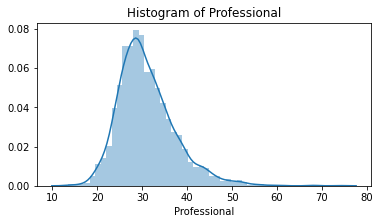

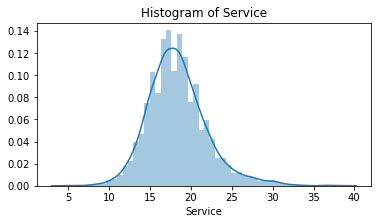

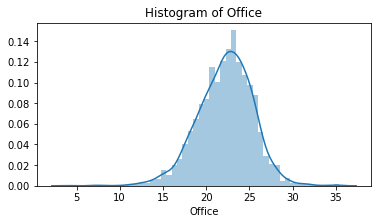

In [7]:
# Look at distribution of numerical data
for a in ['Professional', 'Service', 'Office']:
    ax=plt.subplots(figsize=(6,3))
    ax=sns.distplot(counties[a])
    title="Histogram of " + a
    ax.set_title(title, fontsize=12)
    plt.show()

In [8]:
# MinMaxScaler to scale the numerical columns so that they fall between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
counties_scaled=pd.DataFrame(scaler.fit_transform(counties))
counties_scaled.columns=counties.columns
counties_scaled.index=counties.index

In [9]:
# Final preprocessed dataset
counties_scaled.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,0.005475,0.005381,0.005566,0.026026,0.759519,0.215367,0.004343,0.024038,0.0,0.006702,0.361050,0.100593,0.319748,0.063816,0.183121,0.227941,0.325620,0.361446,0.642173,0.178756,0.307554,0.920582,0.294314,0.001621,0.007022,0.033248,0.048387,0.552430,0.005139,0.750000,0.250000,0.150273,0.000000,0.208219
Alabama-Baldwin,0.019411,0.019246,0.019572,0.045045,0.832665,0.110594,0.006515,0.016827,0.0,0.024393,0.351957,0.047095,0.358980,0.039464,0.191083,0.235294,0.323967,0.382530,0.734824,0.235751,0.201439,0.889262,0.294314,0.001621,0.014045,0.035806,0.104839,0.549872,0.018507,0.884354,0.107616,0.158470,0.040816,0.205479
Alabama-Barbour,0.002656,0.002904,0.002416,0.046046,0.462926,0.543655,0.002172,0.009615,0.0,0.003393,0.198886,0.128195,0.183283,0.045206,0.402866,0.555147,0.219835,0.334337,0.607029,0.235751,0.415468,0.879195,0.364548,0.006483,0.025281,0.038363,0.043011,0.491049,0.001819,0.719388,0.248344,0.199454,0.010204,0.482192
Alabama-Bibb,0.002225,0.002414,0.002042,0.022022,0.746493,0.249127,0.004343,0.002404,0.0,0.002860,0.249473,0.176666,0.210191,0.099320,0.245223,0.341912,0.132231,0.388554,0.437700,0.448187,0.426259,0.872483,0.451505,0.008104,0.008427,0.038363,0.018817,0.611253,0.001754,0.804422,0.170530,0.183060,0.040816,0.227397
Alabama-Blount,0.005722,0.005738,0.005707,0.086086,0.880762,0.017462,0.003257,0.002404,0.0,0.006970,0.312641,0.136163,0.245370,0.039266,0.243631,0.333333,0.247934,0.274096,0.632588,0.305699,0.357914,0.891499,0.374582,0.006483,0.012640,0.010230,0.061828,0.767263,0.004751,0.892857,0.127483,0.114754,0.040816,0.210959


### 4. Create a Model

We will use SageMaker's PCA to start training job

##### Dimensionality reduction
We will be using principal component analysis (PCA) to reduce the dimensionality of our data. This method decomposes the data matrix into features that are orthogonal with each other. The resultant orthogonal features are linear combinations of the original feature set. You can think of this method as taking many features and combining similar or redundant features together to form a new, smaller feature set.

We can reduce dimensionality with the built-in Amazon SageMaker algorithm for PCA.

We first import and call an instance of the PCA SageMaker model. Then we specify different parameters of the model. These can be resource configuration parameters, such as how many instances to use during training, or what type of instances to use. Or they can be model computation hyperparameters, such as how many components to use when performing PCA. Documentation on the PCA model can be found here: http://sagemaker.readthedocs.io/en/latest/pca.html

In [10]:
from sagemaker import PCA
num_components=33

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path='s3://'+ bucket +'/counties/',
             num_components=num_components)

###### Prepare data for Amazon SageMaker by extracting the numpy array from the DataFrame and explicitly casting to float32

In [11]:
train_data = counties_scaled.values.astype('float32')

The record_set function in the Amazon SageMaker PCA model converts a numpy array into a record set format that is the required format for the input data to be trained. This is a requirement for all Amazon SageMaker built-in models. The use of this data type is one of the reasons that allows training of models within Amazon SageMaker to perform faster, for larger data sets compared with other implementations of the same models, such as the sklearn implementation.

We call the fit function on our PCA model, passing in our training data, and this spins up a training instance or cluster to perform the training job.

### 5. Start Training

In [12]:
%%time
pca_SM.fit(pca_SM.record_set(train_data))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-07-12 08:04:42 Starting - Starting the training job...
2020-07-12 08:04:45 Starting - Launching requested ML instances......
2020-07-12 08:05:53 Starting - Preparing the instances for training......
2020-07-12 08:07:10 Downloading - Downloading input data...
2020-07-12 08:07:39 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/12/2020 08:07:43 INFO 140096930195264] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[07/12/2020 08:07:43 INFO 140096930195264] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'34', u'mini_batch_size':

##### Accessing the PCA model attributes
After the model is created, we can also access the underlying model parameters.

Now that the training job is complete, you can find the job under Jobs in the Training subsection in the Amazon SageMaker console.

Model artifacts are stored in Amazon S3 after they have been trained. This is the same model artifact that is used to deploy a trained model using Amazon SageMaker. Since many of the Amazon SageMaker algorithms use MXNet for computational speed, the model artifact is stored as an ND array. For an output path that was specified during the training call, the model resides in <training_job_name>/output/model.tar.gz file, which is a TAR archive file compressed with GNU zip (gzip) compression.

In [13]:
job_name = pca_SM.latest_training_job.name
model_key = "counties/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')

0

After the model is decompressed, we can load the ND array using MXNet.

In [14]:
import mxnet as mx
pca_model_params = mx.ndarray.load('model_algo-1')

##### Three groups of model parameters are contained within the PCA model.

1. **mean**: is optional and is only available if the “subtract_mean” hyperparameter is true when calling the training step from the original PCA SageMaker function.

2. **v**: contains the principal components (same as ‘components_’ in the sklearn PCA model).

3. **s**: the singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.

explained-variance-ratio ~= square(s) / sum(square(s))

To calculate the exact explained-variance-ratio vector if needed, it simply requires saving the sum of squares of the original data (call that N) and computing explained-variance-ratio = square(s) / N.

In [15]:
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

We can now calculate the variance explained by the largest n components that we want to keep. For this example, let's take the top 5 components.

We can see that the largest 5 components explain ~72% of the total variance in our dataset:

In [16]:
s.iloc[28:,:].apply(lambda x: x*x).sum()/s.apply(lambda x: x*x).sum()

0    0.717983
dtype: float32

After we have decided to keep the top 5 components, we can take only the 5 largest components from our original s and v matrix.

In [17]:
s_5=s.iloc[28:,:]
v_5=v.iloc[:,28:]
v_5.columns=[0,1,2,3,4]

We can now examine the makeup of each PCA component based on the weightings of the original features that are included in the component. For example, the following code shows the first component. We can see that this component describes an attribute of a county that has high poverty and unemployment, low income and income per capita, and high Hispanic/Black population and low White population.

Note that this is v_5[4] or last component of the list of components in v_5, but is actually the largest component because the components are ordered from smallest to largest. So v_5[0] would be the smallest component. Similarly, change the value of component_num to cycle through the makeup of each component.

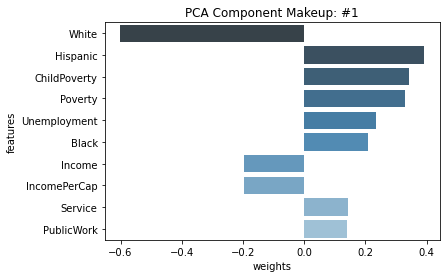

In [18]:
component_num=1

first_comp = v_5[5-component_num]
comps = pd.DataFrame(list(zip(first_comp, counties_scaled.columns)), columns=['weights', 'features'])
comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
ax=sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

Similarly, you can go through and examine the makeup of each PCA components and try to understand what the key positive and negative attributes are for each component. The following code names the components, but feel free to change them as you gain insight into the unique makeup of each component.

In [19]:
PCA_list=['comp_1', 'comp_2', 'comp_3', 'comp_4', 'comp_5']

#PCA_list=["Poverty/Unemployment", "Self Employment/Public Workers", "High Income/Professional & Office Workers", \
#         "Black/Native Am Populations & Public/Professional Workers", "Construction & Commuters"]

### 6. Deploy the model

In [20]:
%%time
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                                 instance_type='ml.p2.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!Wall time: 7min 36s


We can also pass our original dataset to the model so that we can transform the data using the model we created. Then we can take the largest 5 components and this will reduce the dimensionality of our data from 34 to 5.

In [21]:
result = pca_predictor.predict(train_data)

In [22]:
counties_transformed=pd.DataFrame()
for a in result:
    b=a.label['projection'].float32_tensor.values
    counties_transformed=counties_transformed.append([list(b)])
counties_transformed.index=counties_scaled.index
counties_transformed=counties_transformed.iloc[:,28:]
counties_transformed.columns=PCA_list

Now we have created a dataset where each county is described by the 5 principle components that we analyzed earlier. Each of these 5 components is a linear combination of the original feature space. We can interpret each of these 5 components by analyzing the makeup of the component shown previously.

In [23]:
counties_transformed.head()

,comp_1,comp_2,comp_3,comp_4,comp_5
Alabama-Autauga,-0.010824,0.120480,-0.088356,0.160527,-0.060274
Alabama-Baldwin,-0.068677,-0.023092,-0.145743,0.185969,-0.149684
Alabama-Barbour,0.093111,0.297829,0.146258,0.296662,0.506202
Alabama-Bibb,0.283526,0.011757,0.224402,0.190861,0.069224
Alabama-Blount,0.100738,-0.193824,0.022714,0.254403,-0.091030


##### Close the instance and delete endpoint

In [24]:
sagemaker.Session().delete_endpoint(pca_predictor.endpoint)

### 7. Population segmentation using unsupervised clustering

Now, we’ll use the Kmeans algorithm to segment the population of counties by the 5 PCA attributes we have created. Kmeans is a clustering algorithm that identifies clusters of similar counties based on their attributes. Since we have ~3000 counties and 34 attributes in our original dataset, the large feature space may have made it difficult to cluster the counties effectively. Instead, we have reduced the feature space to 5 PCA components, and we’ll cluster on this transformed dataset.

In [25]:
train_data = counties_transformed.values.astype('float32')

- Call and define the hyperparameters of our KMeans model as we have done with our PCA model. 
- Kmeans algorithm allows the user to specify how many clusters to identify. Here, let's try to find the top 7 clusters from our dataset.

In [26]:
from sagemaker import KMeans

# Create a Model
num_clusters = 7
kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket +'/counties/',              
                k=num_clusters)

In [27]:
# Start traning
kmeans.fit(kmeans.record_set(train_data))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-07-12 08:16:26 Starting - Starting the training job...
2020-07-12 08:16:28 Starting - Launching requested ML instances......
2020-07-12 08:17:34 Starting - Preparing the instances for training.........
2020-07-12 08:19:24 Downloading - Downloading input data
2020-07-12 08:19:24 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/12/2020 08:19:47 INFO 139967031703360] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'e

In [28]:
# deploy the model 
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

In [29]:
result=kmeans_predictor.predict(train_data)

#### We can see the breakdown of cluster counts and the distribution of clusters.

In [30]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

In [31]:
pd.DataFrame(cluster_labels)[0].value_counts()

3.0    1005
1.0     645
4.0     500
0.0     372
2.0     364
6.0     239
5.0      93
Name: 0, dtype: int64

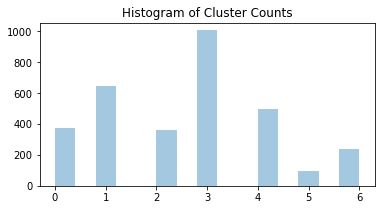

In [32]:
ax=plt.subplots(figsize=(6,3))
ax=sns.distplot(cluster_labels, kde=False)
title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

However, to improve explainability, we need to access the underlying model to get the cluster centers. These centers will help describe which features characterize each cluster.

### 8. Drawing conclusions from our modelling

In [33]:
# we will go into the bucket where the kmeans model is stored and extract it.
job_name = kmeans.latest_training_job.name
model_key = "counties/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')

0

In [34]:
Kmeans_model_params = mx.ndarray.load('model_algo-1')

###### There is 1 set of model parameters that is contained within the KMeans model.

Cluster Centroid Locations: The location of the centers of each cluster identified by the Kmeans algorithm. The cluster location is given in our PCA transformed space with 5 components, since we passed the transformed PCA data into the model.

In [35]:
cluster_centroids=pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns=counties_transformed.columns

In [36]:
cluster_centroids

,comp_1,comp_2,comp_3,comp_4,comp_5
0,0.103042,0.243035,0.095152,0.231477,0.353773
1,-0.025728,-0.035504,-0.130676,0.071708,-0.248759
2,-0.064987,0.103109,-0.221276,0.046815,0.056728
3,-0.038574,-0.086701,0.147747,0.100367,-0.095894
4,0.057833,0.042717,0.061104,-0.295199,-0.210848
5,-0.115543,-0.421144,-0.172118,-0.240359,1.295848
6,0.057550,-0.080885,-0.066903,-0.281058,0.379312


We can plot a heatmap of the centroids and their location in the transformed feature space. This gives us insight into what characteristics define each cluster. Often with unsupervised learning, results are hard to interpret. This is one way to make use of the results of PCA plus clustering techniques together. Since we were able to examine the makeup of each PCA component, we can understand what each centroid represents in terms of the PCA components that we intepreted previously.

For example, we can see that cluster 1 has the highest value in the "Construction & Commuters" attribute while it has the lowest value in the "Self Employment/Public Workers" attribute compared with other clusters. Similarly, cluster 4 has high values in "Construction & Commuters," "High Income/Professional & Office Workers," and "Self Employment/Public Workers."

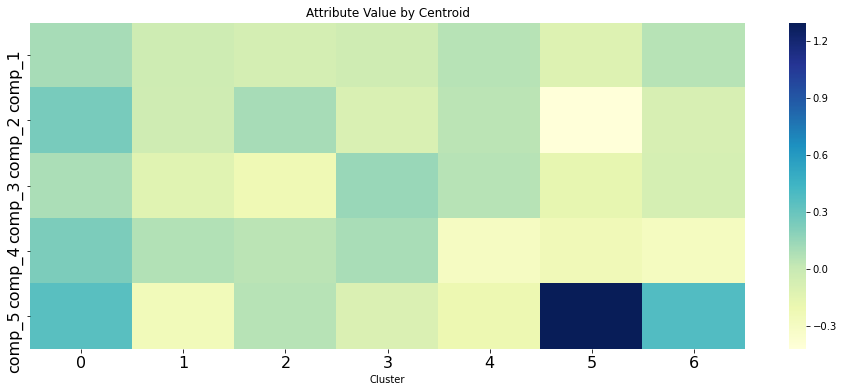

In [37]:
plt.figure(figsize = (16, 6))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [38]:
# Map the cluster labels back to each individual county and examine which counties were naturally grouped together
counties_transformed['labels']=list(map(int, cluster_labels))
counties_transformed.head()

,comp_1,comp_2,comp_3,comp_4,comp_5,labels
Alabama-Autauga,-0.010824,0.120480,-0.088356,0.160527,-0.060274,2
Alabama-Baldwin,-0.068677,-0.023092,-0.145743,0.185969,-0.149684,1
Alabama-Barbour,0.093111,0.297829,0.146258,0.296662,0.506202,0
Alabama-Bibb,0.283526,0.011757,0.224402,0.190861,0.069224,3
Alabama-Blount,0.100738,-0.193824,0.022714,0.254403,-0.091030,3


In [39]:
# Let's look at cluster 1 for example. 
# it has the highest value for the "Construction & Commuters" attribute. We can now see which counties fit that description.
cluster=counties_transformed[counties_transformed['labels']==1]
cluster.head(5)

,comp_1,comp_2,comp_3,comp_4,comp_5,labels
Alabama-Baldwin,-0.068677,-0.023092,-0.145743,0.185969,-0.149684,1
Alabama-Limestone,0.033746,0.014973,-0.089967,0.151180,-0.089334,1
Alabama-St. Clair,0.008413,-0.072023,-0.060966,0.265235,-0.138401,1
Alabama-Shelby,-0.027054,0.063357,-0.419348,0.164189,-0.275941,1
Alaska-Matanuska-Susitna Borough,0.134903,0.036710,-0.163688,-0.063875,-0.190825,1


### Conclusion
You have just walked through a data science workflow for unsupervised learning, specifically clustering a dataset using KMeans after reducing the dimensionality using PCA. By accessing the underlying models created within Amazon SageMaker, we were able to improve the explainability of our modelling and draw actionable conclusions. Using these techniques, we have been able to better understand the essential characteristics of different counties in the US and segment the electorate into groupings accordingly.

### 9. Close the SageMaker Instance

In [40]:
# sagemaker.Session().delete_endpoint(pca_predictor.endpoint)

In [41]:
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)

Reference
>https://aws.amazon.com/blogs/machine-learning/analyze-us-census-data-for-population-segmentation-using-amazon-sagemaker/